In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from PIL import Image
import time
from fastprogress import master_bar, progress_bar

import torch
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchsummary import summary

rcParams['figure.figsize'] = (14, 6)

In [2]:
!pwd

/home/ah19/live-time-monitoring/GTSRB/models


In [3]:
import sys
sys.path.append('/home/ah19/live-time-monitoring/utilities')

In [4]:
from utils import *

In [2]:
from pathlib import Path

base = Path("/home/ah19/live-time-monitoring")
gtsrb = base / 'GTSRB'

base, gtsrb

(PosixPath('/home/ah19/live-time-monitoring'),
 PosixPath('/home/ah19/live-time-monitoring/GTSRB'))

In [7]:
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed(config['seed'])

# Load Data

In [6]:
feature_names = {0: "20_speed",1: "30_speed",2: "50_speed",3: "60_speed",4: "70_speed",5: "80_speed",6: "80_lifted",7: "100_speed",8: "120_speed",
        9: "no_overtaking_general",10: "no_overtaking_trucks",11: "right_of_way_crossing",12: "right_of_way_general",13: "give_way",14: "stop",
        15: "no_way_general",16: "no_way_trucks",17: "no_way_one_way",18: "attention_general",19: "attention_left_turn",20: "attention_right_turn",
        21: "attention_curvy",22: "attention_bumpers",23: "attention_slippery",24: "attention_bottleneck",25: "attention_construction",
        26: "attention_traffic_light",27: "attention_pedestrian",28: "attention_children",29: "attention_bikes",30: "attention_snowflake",
        31: "attention_deer",32: "lifted_general",33: "turn_right",34: "turn_left",35: "turn_straight",36: "turn_straight_right",
        37: "turn_straight_left",38: "turn_right_down",39: "turn_left_down",40: "turn_circle",41: "lifted_no_overtaking_general",
        42: "lifted_no_overtaking_trucks"}

In [7]:
class GTSRB(Dataset):
    def __init__(self, root, csv_file, transform=None):
        self.root = root
        self.data = pd.read_csv(root / csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.root / self.data.iloc[index, 0])
        label = torch.tensor( self.data.iloc[index, 1] )
        
        if self.transform:
            img = self.transform(img)

        return (img, label)

In [96]:
tf = T.Compose([
    T.ToTensor(),
    T.Resize((30, 30))
])

train_full = GTSRB(gtsrb / 'data' / 'gtsrb_ppm' / 'trainingset', 'training.csv', tf)

len(train_full)

39208

# Data Augmentation

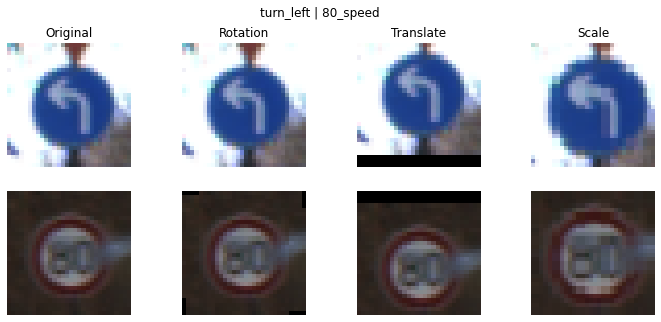

In [10]:
img, label = next( iter( DataLoader(train_full, 2, True) ) )

fig, axs = plt.subplots( 2, 4, figsize=(3 *4, 5) )

[a.set_title(x) for a, x in zip(axs[0], ["Original", "Rotation", "Translate", "Scale"])]
[a.set_axis_off() for a in axs[0]]
[a.set_axis_off() for a in axs[1]]

fig.suptitle(f"{feature_names[label[0].item()]} | {feature_names[label[1].item()]}")

axs[0, 0].imshow( img[0].permute(1, 2, 0) )
axs[0, 1].imshow( T.RandomAffine(25 )(img[0]).permute(1, 2, 0) )
axs[0, 2].imshow( T.RandomAffine(0, translate=(0, 0.1) )(img[0]).permute(1, 2, 0) )
axs[0, 3].imshow( T.RandomAffine(0, scale=(1, 1.25) )(img[0]).permute(1, 2, 0) )

axs[1, 0].imshow( img[1].permute(1, 2, 0) )
axs[1, 1].imshow( T.RandomAffine(25 )(img[1]).permute(1, 2, 0) )
axs[1, 2].imshow( T.RandomAffine(0, translate=(0, 0.1) )(img[1]).permute(1, 2, 0) )
axs[1, 3].imshow( T.RandomAffine(0, scale=(1, 1.25) )(img[1]).permute(1, 2, 0) )


# plt.savefig(base / 'Important for writing' / 'gtsrb_aug_good.jpg', transparent=False, dpi=100)

plt.show()

# Analyzind Class Weights

In [97]:
def get_class_weights(dataloader):
    c = np.zeros(43)

    for _, label in dataloader:
        c += np.bincount(label.numpy(), minlength=43)

    return c

def get_instance_weights(dataloader):

    weight_classes = get_class_weights(dataloader)
    weight_classes_normlized = 1 / weight_classes
    
    weights_intances = np.array([])

    for _, label in dataloader:
        weights_intances = np.append(weights_intances, weight_classes_normlized[label.numpy()])

    return weight_classes, weights_intances


In [98]:
train_dataloader = get_dataLoader(train_full, 256)

In [99]:
train_weight_classes, train_weights_intances = get_instance_weights(train_dataloader)

# Balanced Dataset

In [100]:
train_num_instances = 1800

train_sampler = WeightedRandomSampler(train_weights_intances, 43 * train_num_instances)

train_dataloader = get_dataLoader(train_full, 256, sampler=train_sampler, collate_fn=collat_fn_augmentation)

In [101]:
balanced_collat_classes_train = get_class_weights(train_dataloader)

In [119]:
balanced_collat_classes_train

array([1828., 1829., 1822., 1809., 1780., 1860., 1689., 1782., 1798.,
       1806., 1807., 1781., 1741., 1793., 1823., 1876., 1752., 1809.,
       1794., 1825., 1836., 1819., 1704., 1753., 1779., 1744., 1815.,
       1841., 1852., 1771., 1823., 1817., 1761., 1845., 1782., 1866.,
       1787., 1820., 1738., 1879., 1727., 1795., 1842.])

# Saving augmented images

In [4]:
folder_path = gtsrb / 'data' / 'gtsrb_aug'
folder_path.mkdir(exist_ok=True)
folder_path

PosixPath('/home/ah19/live-time-monitoring/GTSRB/data/gtsrb_aug')

In [5]:
trainfolder_path = folder_path / 'trainingset'
trainfolder_path.mkdir(exist_ok=True)
trainfolder_path

PosixPath('/home/ah19/live-time-monitoring/GTSRB/data/gtsrb_aug/trainingset')

In [112]:
range_num_classes = range(43)

for i in range_num_classes:
    (trainfolder_path / str(i)).mkdir(exist_ok=True)

In [122]:
counter = {i: 0 for i in range_num_classes}

In [138]:
import csv

f = trainfolder_path / 'training.csv'
f.touch()
mb = master_bar( range(len(train_dataloader)) )

with f.open('w+', newline='') as ff:

    writer = csv.writer(ff)
    writer.writerow(['label', 'path'])

    for _, (img, label) in zip(mb, train_dataloader):
        for i, l in zip(img, label):
            img_name = f"{str(l.item()).zfill(2)}_{str(counter[l.item()]).zfill(4)}"
            T.ToPILImage()(i).save(trainfolder_path / str(l.item()) / f'{img_name}.ppm' )
            writer.writerow([str(l.item()), f'{str(l.item())}/{img_name}.ppm'])

            counter[l.item()] += 1

In [6]:
f = trainfolder_path / 'training.csv'
df_aug = pd.read_csv(f)

In [7]:
df_aug.head()

,label,path
0,3,3/0000.ppm
1,39,39/0000.ppm
2,39,39/0001.ppm
3,33,33/0000.ppm
4,11,11/0000.ppm


<AxesSubplot:>

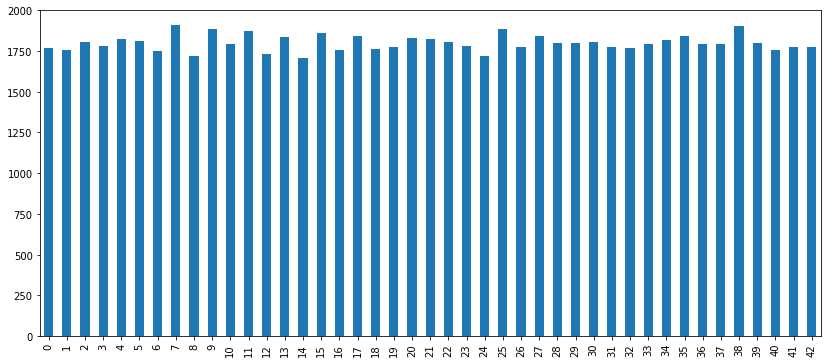

In [8]:
df_aug.label.value_counts().sort_index().plot.bar()